# Homework 2
### Sean Morton, ME449

In [1]:
#imports
import core as mr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [38]:
#variables determined from project description
W1 = 0.109 #changed mm to m
W2 = 0.082
L1 = 0.425
L2 = 0.392
H1 = 0.089
H2 = 0.095

Blist = np.matrix([
    [0,  1, 0, (W1 + W2),          0, (L1 + L2)],
    [0,  0, 1,        H2, -(L1 + L2),         0],
    [0,  0, 1,        H2,        -L2,         0],
    [0,  0, 1,        H2,          0,         0],
    [0, -1, 0,       -W2,          0,         0],
    [0,  0, 1,         0,          0,         0]
]).T

Tsd = [
    [-1, 0, 0, -0.2],
    [0,  0, 1,  0.6],
    [0,  1, 0, 0.35],
    [0,  0, 0,    1]
]

M = np.matrix([
    [-1, 0, 0, (L1 + L2)],
    [ 0, 0, 1, (W1 + W2)],
    [ 0, 1, 0, (H1 - H2)],
    [ 0, 0, 0,         1]
])

eomg = 0.001 #rad
ev = 0.0001 #m

In [3]:
#helper functions
def find_twist_for_error(M, Jb, Tsb, thetalist):
    '''
    - inputs: M, theta_list, Jb or Js, target transf. Tsb
    - calculate current transformation matrix of e.e. Tsa from:
        - starting config M
        - joint angles theta_list
        - Jacobian of robot in S or B frame
    - find Tab: Tab = (Tsa)^-1 Tsb
    - find twist by [V]*t = log(Tab)
        - assume rotating w/ twist for unit time 1sec will
            give trans. matrix
    - V = se3ToVec([V])
    '''
    
    #find transformation that describes difference between 
    #current position and desired position
    Tsa = mr.FKinBody(M, Jb, thetalist)
    Tab = mr.TransInv(Tsa) * Tsb
    
    #assume V*(1sec) gives transformation
    se3_Vt = mr.MatrixLog6(Tab)    
    V = mr.se3ToVec(se3_Vt)
    
    return V

###############

#testing

theta_list = np.array([3.14159, 3.14159, 3.14159, 3.14159, 3.14159, 3.14159])
T_result = np.array([
    [-1, 0, 0, 0.033],
    [0, 0, 1, -0.027],
    [0, 1, -0, 0.184],
    [0, 0,  0,     1]
]) #resulting transformation from these changes, from CoppeliaSim

T_desired = [
    [0.695,  0.719, 0,  0.729],
    [    0,      0, 1, -0.027],
    [0.719, -0.695, 0,  0.093],
    [    0,      0, 0,      1]
] #I think this is achievable by the robot based on joints + links

Tab = mr.TransInv(T_result) * T_desired
se3mat = mr.MatrixLog6(Tab)

V1 = mr.se3ToVec(se3mat)
V2 = find_twist_for_error(M, Jb, T_desired, theta_list)

#print as scientific
np.set_printoptions(suppress=True)

assert np.allclose(V1, V2, atol = 0.001, rtol = 0.001), \
            f"Actual twists calculated: \nV1:{V1} \nV2:{V2}"

In [4]:
def calculate_V_error(V):
    '''
    - inputs: a twist V
    - outputs: [eomg_curr, elin_curr]
    '''
    w = V[0:3]
    v = V[3:6]
    mag_w = np.linalg.norm(w)
    mag_v = np.linalg.norm(v)
    return np.array([mag_w, mag_v])

#######

V = np.array([2,4,5,6,7,9])
error = calculate_V_error(V)
expected = [np.sqrt(45), np.sqrt(166)]

assert np.allclose(expected, error), f"Observed error: {error}"


In [41]:
def convert_theta_to_xyz(M, Blist, csv_filepath):
    '''
    - write function to convert a series of joint angles into positions 
    in xyz coords of the end effector
        - inputs: M, Blist/Slist, csv_filepath
        - opens and iterates through CSV file
        - uses: FKinBody() or FKinSpace(), inputs M, Blist/Slist, thetalist
        - calculate a transformation matrix that results from 
            the joint angles applied
        - take home configuration of robot and pre- or post-multiply
            transformation from joint angles
        - use [R,p] = TransToRp(T) to get the translation of the end
            effector rel. to. body frame; extract set x,y,z = p
        - outputs a list of lists, [ [x,y,z], [x,y,z], ...) 
        
    Used for plotting the positions of the end effector over time.
    '''
    df = pd.read_csv(csv_filepath, header=None)
    p_list = []
    
    for ind, row in df.iterrows():
        angles = row.tolist()
        
        #apply forward kinematics with given angles; extract xyz and R
        Jb = mr.JacobianBody(Blist, angles)
        T = mr.FKinBody(M, Jb, angles)
        [_, p] = mr.TransToRp(T)
        p = p.round(3).tolist()
        p_list.append(p)
    
    ####
    return p_list
        
#######

expected = [
    [-0.594, -0.167, -0.162],
    [-0.055,  0.100, -0.364],
    [ 0.033, -0.027,  0.184],
    [ 0.817,  0.191,  0.005],
]

local_csv = "test_hw2_angles.csv"
p_list = convert_theta_to_xyz(M, Blist,local_csv)

#these tolerances make no sense, but I verified by inspection
#that observed elements are close to expected elements within 0.001

#this isn't right - make sure to review in CoppeliaSim and make sure Jacobian
#methods work right

assert np.allclose(expected, p_list, atol = 0.02, rtol = 0.02), \
        f"Observed result: {p_list}"

AssertionError: Observed result: [[1.599, 0.582, -0.752], [0.66, 0.572, 0.207], [1.601, 0.409, -0.196], [0.817, 0.191, -0.006]]

In [6]:
def write_csv_line(csv_filename, data):
    with open(csv_filename, 'a') as f:
        data_str = ','.join([str(i) for i in data]) + '\n'
        f.write(data_str)
    
####

fname = "CSVwrite_test.csv"
data = [0, 22.45, 0.987, 2262]
write_csv_line(fname, data)

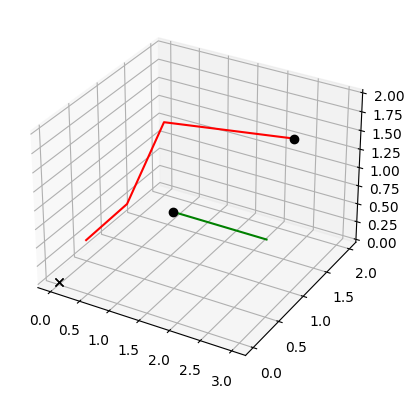

In [13]:
# def xyz_over_time_figure(xyz_list):
def xyz_over_time_figure(ax, xyz_list, target_xyz, color='gray', label=None):

    '''
    - write function to display x, y, z posns over time
        - inputs: xyz_list, a list of lists of xyz coords
        - take in the CSV file for this so we don't have to write 
            code for it that depends on prev. outputs in the Jupyter notebook
        - look up a python library that can do 3D plots you can rotate
        - find out how to do line plots
        - have target_posn be an input; calculate initial_posn from array
            indexing
        - outputs: a figure; display it when ready
    '''
    xdata = [posn[0] for posn in xyz_list]
    ydata = [posn[1] for posn in xyz_list]
    zdata = [posn[2] for posn in xyz_list]
    
    ax.plot(xdata, ydata, zdata, color=color, label=label)
    ax.plot(*target_xyz, color='black', marker='x')
    ax.plot(*xyz_list[0], color='black', marker='o')

    return ax

####

#sample x, y, z
xyz_test = [
    [3, 1, 2],
    [0, 2, 1],
    [0.25, 1, 0.5],
    [0, 0.5, 0.25]
]

xyz_test2 = [
    [1.5, 0.5, 1],
    [3, 0.5, 1]
]

target_xyz = [0, 0, 0]

fig = plt.figure()
ax = plt.axes(projection='3d')
ax = xyz_over_time_figure(ax, xyz_test, target_xyz, 'red')
ax = xyz_over_time_figure(ax, xyz_test2, target_xyz, 'green')

plt.show()


In [33]:
#try to find the joint vector that IKinBody returns to see if my function is working
theta_list_sol, success = mr.IKinBody(Blist, M, T, theta_list_sol, eomg, ev)
display(theta_list_sol)
display(success)

NameError: name 'Blist' is not defined

In [32]:
#the main event

#modified this version of function to only iterate once
def mod_IKinBody(Blist, M, T, thetalist0, eomg, ev):
    """Computes inverse kinematics in the body frame for an open chain robot

    :param Blist: The joint screw axes in the end-effector frame when the
                  manipulator is at the home position, in the format of a
                  matrix with axes as the columns
    :param M: The home configuration of the end-effector
    :param T: The desired end-effector configuration Tsd
    :param thetalist0: An initial guess of joint angles that are close to
                       satisfying Tsd
    :param eomg: A small positive tolerance on the end-effector orientation
                 error. The returned joint angles must give an end-effector
                 orientation error less than eomg
    :param ev: A small positive tolerance on the end-effector linear position
               error. The returned joint angles must give an end-effector
               position error less than ev
    :return thetalist: Joint angles that achieve T within the specified
                       tolerances,
    :return success: A logical value where TRUE means that the function found
                     a solution and FALSE means that it ran through the set
                     number of maximum iterations without finding a solution
                     within the tolerances eomg and ev.
    Uses an iterative Newton-Raphson root-finding method.
    The maximum number of iterations before the algorithm is terminated has
    been hardcoded in as a variable called maxiterations. It is set to 20 at
    the start of the function, but can be changed if needed.

    Example Input:
        Blist = np.array([[0, 0, -1, 2, 0,   0],
                          [0, 0,  0, 0, 1,   0],
                          [0, 0,  1, 0, 0, 0.1]]).T
        M = np.array([[-1, 0,  0, 0],
                      [ 0, 1,  0, 6],
                      [ 0, 0, -1, 2],
                      [ 0, 0,  0, 1]])
        T = np.array([[0, 1,  0,     -5],
                      [1, 0,  0,      4],
                      [0, 0, -1, 1.6858],
                      [0, 0,  0,      1]])
        thetalist0 = np.array([1.5, 2.5, 3])
        eomg = 0.01
        ev = 0.001
    Output:
        (np.array([1.57073819, 2.999667, 3.14153913]), True)
    """
    thetalist = np.array(thetalist0).copy()
    i = 0
    maxiterations = 1
    Vb = mr.se3ToVec(mr.MatrixLog6(np.dot(mr.TransInv(mr.FKinBody(M, Blist, \
                                                      thetalist)), T)))
    err = np.linalg.norm([Vb[0], Vb[1], Vb[2]]) > eomg \
          or np.linalg.norm([Vb[3], Vb[4], Vb[5]]) > ev
    while err and i < maxiterations:
        thetalist = thetalist \
                    + np.dot(np.linalg.pinv(mr.JacobianBody(Blist, \
                                                         thetalist)), Vb)
        i = i + 1
        Vb \
        = mr.se3ToVec(mr.MatrixLog6(np.dot(mr.TransInv(mr.FKinBody(M, Blist, \
                                                       thetalist)), T)))
        err = np.linalg.norm([Vb[0], Vb[1], Vb[2]]) > eomg \
              or np.linalg.norm([Vb[3], Vb[4], Vb[5]]) > ev
    return (thetalist, not err)

#####

def IKinBodyIterates(Blist, M, T, thetalist0, eomg, ev, max_iterates):
    '''
    - uses IKinBody (Blist, M, T, thetalist0, eomg, ev),
        find_twist_for_error(M, Jb, Tsb, thetalist),
        calculate_V_error(V)
    - after each iteration, calculate current trans. matrix, twist error,
        and linear/angular errors
    '''    
    theta_list = thetalist0
    Jb = mr.JacobianBody(Blist, theta_list)
    T0 = mr.FKinBody(M, Jb, thetalist0)
    V = find_twist_for_error(M, Jb, T, theta_list)
    [mag_w, mag_v] = calculate_V_error(V)   
    
    
    iter = 0
    joint_vectors = []
        
    while ((iter < max_iterates) and ( (mag_w > eomg) or (mag_v > ev) )):
           
        [theta_list_new, solved] = mod_IKinBody(Blist, M, T, theta_list, eomg, ev)
        Jb = mr.JacobianBody(Blist, theta_list_new)
        T_curr = mr.FKinBody(M, Jb, theta_list_new)
        V = find_twist_for_error(M, Jb, T, theta_list_new)
        [mag_w, mag_v] = calculate_V_error(V)
        
        joint_vectors.append(theta_list_new)
        
        #outputs, can be changed
        print(f"\nIteration {iter}:\n")
        print(f"Joint vector: \n{theta_list_new.round(3).tolist()}\n")    
        print(f"SE(3) end-effector config: \n{T_curr.round(3)}\n")        
        print(f"          error twist V_b: {V.round(3).tolist()}")
        print(f"angular error ||omega_b||: {round(mag_w, 3)}")
        print(f"     linear error ||v_b||: {round(mag_v, 3)}")
        
        ####
        #prep outputs for next iteration
        theta_list = theta_list_new
        iter += 1
        
    return joint_vectors

####

#test with an initial configuration
# thetalist0 = [0,0,0,0,0,0]
#thetalist0 = [0.501, -2.126, 3.523, 8.734, 0.501, -10.131]
thetalist0 = [-2.994, 17.959, -9.488, 36.841, 3.501, 32.883]
short_iterates = 5
long_iterates = 10

joint_vectors_far = IKinBodyIterates(Jb, M, Tsd, thetalist0, eomg, ev, long_iterates)


Iteration 0:

Joint vector: 
[8.329, -93.129, -15.532, 124.371, 5.872, 1.143]

SE(3) end-effector config: 
[[ 0.956 -0.288 -0.056  0.001]
 [-0.09  -0.105 -0.99  -0.565]
 [ 0.28   0.952 -0.126 -0.048]
 [ 0.     0.     0.     1.   ]]

          error twist V_b: [-13.624, 0.0, 0.0, 0.008, 1.487, 3.361]
angular error ||omega_b||: 13.624
     linear error ||v_b||: 3.675

Iteration 1:

Joint vector: 
[13.135, -93.117, -12.159, 117.037, 0.055, 6.239]

SE(3) end-effector config: 
[[-0.717 -0.62  -0.319  0.651]
 [ 0.122 -0.562  0.818 -0.157]
 [-0.687  0.547  0.479  0.958]
 [ 0.     0.     0.     1.   ]]

          error twist V_b: [0.234, 0.0, -0.0, -0.229, -0.13, -0.028]
angular error ||omega_b||: 0.234
     linear error ||v_b||: 0.264

Iteration 2:

Joint vector: 
[14.931, -109.535, 17.01, 132.03, 1.792, -20.717]

SE(3) end-effector config: 
[[-0.246 -0.722  0.647  1.24 ]
 [ 0.912 -0.398 -0.098 -0.037]
 [ 0.328  0.566  0.756 -0.326]
 [ 0.     0.     0.     1.   ]]

          error twist V_b:

In [29]:
#v2: just modify the IKinBody() function

#modified this version of function to only iterate once
def IKinBodyIterates_v2(Blist, M, T, thetalist0, eomg, ev, max_iter):
    """Computes inverse kinematics in the body frame for an open chain robot

    :param Blist: The joint screw axes in the end-effector frame when the
                  manipulator is at the home position, in the format of a
                  matrix with axes as the columns
    :param M: The home configuration of the end-effector
    :param T: The desired end-effector configuration Tsd
    :param thetalist0: An initial guess of joint angles that are close to
                       satisfying Tsd
    :param eomg: A small positive tolerance on the end-effector orientation
                 error. The returned joint angles must give an end-effector
                 orientation error less than eomg
    :param ev: A small positive tolerance on the end-effector linear position
               error. The returned joint angles must give an end-effector
               position error less than ev
    :return thetalist: Joint angles that achieve T within the specified
                       tolerances,
    :return success: A logical value where TRUE means that the function found
                     a solution and FALSE means that it ran through the set
                     number of maximum iterations without finding a solution
                     within the tolerances eomg and ev.
    Uses an iterative Newton-Raphson root-finding method.
    The maximum number of iterations before the algorithm is terminated has
    been hardcoded in as a variable called maxiterations. It is set to 20 at
    the start of the function, but can be changed if needed.

    Example Input:
        Blist = np.array([[0, 0, -1, 2, 0,   0],
                          [0, 0,  0, 0, 1,   0],
                          [0, 0,  1, 0, 0, 0.1]]).T
        M = np.array([[-1, 0,  0, 0],
                      [ 0, 1,  0, 6],
                      [ 0, 0, -1, 2],
                      [ 0, 0,  0, 1]])
        T = np.array([[0, 1,  0,     -5],
                      [1, 0,  0,      4],
                      [0, 0, -1, 1.6858],
                      [0, 0,  0,      1]])
        thetalist0 = np.array([1.5, 2.5, 3])
        eomg = 0.01
        ev = 0.001
    Output:
        (np.array([1.57073819, 2.999667, 3.14153913]), True)
    """
    thetalist = np.array(thetalist0).copy()
    i = 0
    maxiterations = max_iter
    joint_vectors = []
    Vb = mr.se3ToVec(mr.MatrixLog6(np.dot(mr.TransInv(mr.FKinBody(M, Blist, \
                                                      thetalist)), T)))
    err = np.linalg.norm([Vb[0], Vb[1], Vb[2]]) > eomg \
          or np.linalg.norm([Vb[3], Vb[4], Vb[5]]) > ev
    
    while err and i < maxiterations:
        
        
        T_curr = mr.FKinBody(M, Blist, thetalist)
        [mag_w, mag_v] = calculate_V_error(Vb)
        
        print(f"\nIteration {i}:\n")
        print(f"Joint vector: \n{thetalist.round(3).tolist()}\n")    
        print(f"SE(3) end-effector config: \n{T_curr.round(3)}\n")        
        print(f"          error twist V_b: {Vb.round(3).tolist()}")
        print(f"angular error ||omega_b||: {round(mag_w, 3)}")
        print(f"     linear error ||v_b||: {round(mag_v, 3)}")
        
        joint_vectors.append(thetalist)
        
        #-------------------#
        #set up next iteration of loop
        
        thetalist = thetalist \
                    + np.dot(np.linalg.pinv(mr.JacobianBody(Blist, \
                                                         thetalist)), Vb)
        i = i + 1
        Vb \
        = mr.se3ToVec(mr.MatrixLog6(np.dot(mr.TransInv(mr.FKinBody(M, Blist, \
                                                       thetalist)), T)))
        
        err = np.linalg.norm([Vb[0], Vb[1], Vb[2]]) > eomg \
              or np.linalg.norm([Vb[3], Vb[4], Vb[5]]) > ev
        
        
    return (thetalist, not err)

#####

#test with an initial configuration
thetalist0 = [0,0,0,0,0,0]
short_iterates = 5
long_iterates = 10

_,_ = IKinBodyIterates_v2(Jb, M, Tsd, thetalist0, eomg, ev, long_iterates)



Iteration 0:

Joint vector: 
[0, 0, 0, 0, 0, 0]

SE(3) end-effector config: 
[[-1.     0.     0.     0.817]
 [ 0.     0.     1.     0.191]
 [ 0.     1.     0.    -0.006]
 [ 0.     0.     0.     1.   ]]

          error twist V_b: [0.0, 0.0, 0.0, 1.017, 0.356, 0.409]
angular error ||omega_b||: 0.0
     linear error ||v_b||: 1.153

Iteration 1:

Joint vector: 
[0.501, -2.126, 3.523, 8.734, 0.501, -10.131]

SE(3) end-effector config: 
[[-0.64   0.203 -0.741 -0.196]
 [-0.766 -0.244  0.594  0.099]
 [-0.061  0.948  0.311  0.162]
 [ 0.     0.     0.     1.   ]]

          error twist V_b: [0.323, -0.877, -0.083, -0.214, 0.108, 0.497]
angular error ||omega_b||: 0.938
     linear error ||v_b||: 0.552

Iteration 2:

Joint vector: 
[-4.213, -1.982, 4.031, 3.164, 3.21, -4.432]

SE(3) end-effector config: 
[[ 0.451  0.047  0.892  0.105]
 [-0.865 -0.223  0.449 -0.25 ]
 [ 0.22  -0.974 -0.06   0.08 ]
 [ 0.     0.     0.     1.   ]]

          error twist V_b: [1.551, 0.25, -2.537, 0.236, -1.055, 0.67

In [30]:
#for a short-iterates test, grab a point close to the desired config of robot
T_close = [
    [-1, 0, 0, -0],
    [0,  0, 1,  0.5],
    [0,  1, 0, 0.2],
    [0,  0, 0,    1]
]

theta_list_close = (1.310, -1.108, 1.914, 5.071, 6.280, 0.000) #from visual inspection in CSim
joint_vectors_close = IKinBodyIterates_v2(Jb, M, Tsd, theta_list_close, eomg, ev, short_iterates)


Iteration 0:

Joint vector: 
[1.31, -1.108, 1.914, 5.071, 6.28, 0.0]

SE(3) end-effector config: 
[[-0.234 -0.102 -0.967 -0.056]
 [-0.888 -0.382  0.255  0.531]
 [-0.395  0.919 -0.001  0.099]
 [ 0.     0.     0.     1.   ]]

          error twist V_b: [0.265, -1.294, 0.347, 0.027, 0.256, 0.177]
angular error ||omega_b||: 1.366
     linear error ||v_b||: 0.312

Iteration 1:

Joint vector: 
[1.663, -12.4, 37.94, -146.813, 7.899, 127.497]

SE(3) end-effector config: 
[[ 0.342  0.937  0.074 -0.183]
 [-0.885  0.348 -0.31   0.83 ]
 [-0.316  0.041  0.948 -0.029]
 [ 0.     0.     0.     1.   ]]

          error twist V_b: [1.271, -1.717, -1.313, 0.414, 0.343, 0.201]
angular error ||omega_b||: 2.508
     linear error ||v_b||: 0.574

Iteration 2:

Joint vector: 
[0.991, -18.154, 49.961, -151.721, 6.439, 126.881]

SE(3) end-effector config: 
[[-0.467  0.462 -0.754  0.251]
 [-0.616  0.441  0.653  0.73 ]
 [ 0.634  0.769  0.079 -0.408]
 [ 0.     0.     0.     1.   ]]

          error twist V_b: [-0.

In [10]:
#save data to csv so we can access it later.
csv_long = "hw2_data_long.csv"
f = open(csv_long, 'w') #clear out prev. results
f.close()

for vec in joint_vectors_far:
    write_csv_line(csv_long, vec)

csv_short = "hw2_data_short.csv"
f = open(csv_short, 'w') #clear out prev. results
f.close()

for vec in joint_vectors_close:
    write_csv_line(csv_short, vec)

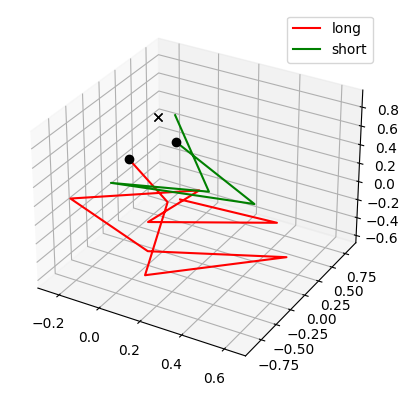

In [14]:
#plot our data
xyz_long = convert_theta_to_xyz(M, Jb,csv_long)
xyz_short = convert_theta_to_xyz(M, Jb,csv_short)
target_xyz = mr.TransToRp(Tsd)[1]

fig = plt.figure()
ax = plt.axes(projection='3d')
ax = xyz_over_time_figure(ax, xyz_long, target_xyz, 'red', label='long')
ax = xyz_over_time_figure(ax, xyz_short, target_xyz, 'green', label='short')
ax.legend()
plt.show()